Importando bibliotecas

In [1]:
import spacy
from spacy.tokens import Doc
from spacy.tokens import Span
import numpy as np
from spacy.tokens import DocBin
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from datasets import load_dataset
import datasets
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns

Criando variáveis binárias indicadoras se executamos ou não partes demoradas do código. Uma vez executada, o resultado fica salvo, n sendo necessária nova execução.

In [2]:
generate_config_file = False
run_model = False
download_pt_core_news_lg = False

Leitura dos dados

In [3]:
dataset = datasets.load_from_disk("../dataset")

In [4]:
df_train = pd.DataFrame(dataset['train'])
df_validation = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

Visualizando parte dos dados

In [5]:
df_train.head()

id                                             tokens   
0  0  [EMENTA, :, APELAÇÃO, CÍVEL, -, AÇÃO, DE, INDE...  \
1  1  [-, O, art, ., 178, ,, II, ,, do, CPC, prescre...   
2  2  [-, Tratando-se, de, ação, indenizatória, ajui...   
3  3  [-, Tendo, o, vício, sido, arguido, pelo, Parq...   
4  4  [-, Preliminar, acolhida, para, reconhecer, a,...   

                                            ner_tags  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 9, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0,...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Adicionar coluna de texto criada a partir dos tokens

In [6]:
df_train["text"] = [" ".join(word) for word in df_train['tokens']]
df_test["text"] = [" ".join(word) for word in df_test['tokens']]
df_validation["text"] = [" ".join(word) for word in df_validation['tokens']]

In [7]:
df_train.head()

id                                             tokens   
0  0  [EMENTA, :, APELAÇÃO, CÍVEL, -, AÇÃO, DE, INDE...  \
1  1  [-, O, art, ., 178, ,, II, ,, do, CPC, prescre...   
2  2  [-, Tratando-se, de, ação, indenizatória, ajui...   
3  3  [-, Tendo, o, vício, sido, arguido, pelo, Parq...   
4  4  [-, Preliminar, acolhida, para, reconhecer, a,...   

                                            ner_tags   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  \
1  [0, 0, 9, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0,...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                text  
0  EMENTA : APELAÇÃO CÍVEL - AÇÃO DE INDENIZAÇÃO ...  
1  - O art . 178 , II , do CPC prescreve que comp...  
2  - Tratando-se de ação indenizatória ajuizada p...  
3  - Tendo o vício sido arguido pelo Parquet nest...  
4  - Preliminar acolhida para reconhecer a nulida...

In [8]:
label_map = {
    0: "sem label",
    1: "B-ORGANIZACAO",
    2: "I-ORGANIZACAO",
    3: "B-PESSOA",
    4: "I-PESSOA",
    5: "B-TEMPO",
    6: "I-TEMPO",
    7: "B-LOCAL",
    8: "I-LOCAL",
    9: "B-LEGISLACAO",
    10: "I-LEGISLACAO",
    11: "B-JURISPRUDENCIA",
    12: "I-JURISPRUDENCIA"
}

In [9]:
df_train[df_train['tokens'].apply(lambda x: len(x) == 0)]

id tokens ner_tags text
7827  7827     []       []

Criar lista de tuplas com posição do caracter inicial do token, posição final, e tag

In [10]:
def process_data(data):
    labels = []
    for _, row in data.iterrows():
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        label = [
            (
                sum(len(word) + 1 for word in tokens[:i]),  
                sum(len(word) + 1 for word in tokens[:i+1]) - 1,  
                label_map.get(tag, "sem label")   
            )
            for i, tag in enumerate(ner_tags)
        ]
        labels.append(label)
    return labels

for data in [df_train, df_validation, df_test]:
    data['labels'] = process_data(data)

Limpando dados sem info

In [11]:
df_train = df_train[df_train['tokens'].apply(lambda x: len(x) > 0)]
df_validation = df_validation[df_validation['tokens'].apply(lambda x: len(x) > 0)]
df_test = df_test[df_test['tokens'].apply(lambda x: len(x) > 0)]

In [12]:
df_train.head()

id                                             tokens   
0  0  [EMENTA, :, APELAÇÃO, CÍVEL, -, AÇÃO, DE, INDE...  \
1  1  [-, O, art, ., 178, ,, II, ,, do, CPC, prescre...   
2  2  [-, Tratando-se, de, ação, indenizatória, ajui...   
3  3  [-, Tendo, o, vício, sido, arguido, pelo, Parq...   
4  4  [-, Preliminar, acolhida, para, reconhecer, a,...   

                                            ner_tags   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  \
1  [0, 0, 9, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0,...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                text   
0  EMENTA : APELAÇÃO CÍVEL - AÇÃO DE INDENIZAÇÃO ...  \
1  - O art . 178 , II , do CPC prescreve que comp...   
2  - Tratando-se de ação indenizatória ajuizada p...   
3  - Tendo o vício sido arguido pelo Parquet nest...   
4  - Preliminar acolhida para reconhecer a nulida...   

                                              labels  
0  [(0, 6, sem label), (7, 8, sem label), (9, 17,...  
1  [(0, 1, sem label), (2, 3, sem label), (4, 7, ...  
2  [(0, 1, sem label), (2, 13, sem label), (14, 1...  
3  [(0, 1, sem label), (2, 7, sem label), (8, 9, ...  
4  [(0, 1, sem label), (2, 12, sem label), (13, 2...

Download da pipeline

In [13]:
if download_pt_core_news_lg:
    !python -m spacy download pt_core_news_lg
    
nlp = spacy.load("pt_core_news_lg")

Criar arquivo com dados de treino e validação no formato requisitado pela library

In [14]:
from spacy.tokens import DocBin
from spacy.util import filter_spans
doc_bin = DocBin()
for index, row in df_train.iterrows():
    text = row['text']
    labels = row['labels']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        print([span.text,span.label_])
        ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)
doc_bin.to_disk("./train.spacy")

['EMENTA', 'sem label']
[':', 'sem label']
['APELAÇÃO', 'sem label']
['CÍVEL', 'sem label']
['-', 'sem label']
['AÇÃO', 'sem label']
['DE', 'sem label']
['INDENIZAÇÃO', 'sem label']
['POR', 'sem label']
['DANOS', 'sem label']
['MORAIS', 'sem label']
['-', 'sem label']
['PRELIMINAR', 'sem label']
['-', 'sem label']
['ARGUIDA', 'sem label']
['PELO', 'sem label']
['MINISTÉRIO', 'B-ORGANIZACAO']
['PÚBLICO', 'I-ORGANIZACAO']
['EM', 'sem label']
['GRAU', 'sem label']
['RECURSAL', 'sem label']
['-', 'sem label']
['NULIDADE', 'sem label']
['-', 'sem label']
['AUSÊNCIA', 'sem label']
['DE', 'sem label']
['INTERVENÇÃO', 'sem label']
['DO', 'sem label']
['PARQUET', 'sem label']
['NA', 'sem label']
['INSTÂNCIA', 'sem label']
['A', 'sem label']
['QUO', 'sem label']
['-', 'sem label']
['PRESENÇA', 'sem label']
['DE', 'sem label']
['INCAPAZ', 'sem label']
['-', 'sem label']
['PREJUÍZO', 'sem label']
['EXISTENTE', 'sem label']
['-', 'sem label']
['PRELIMINAR', 'sem label']
['ACOLHIDA', 'sem label']
['

In [15]:
from spacy.tokens import DocBin
from spacy.util import filter_spans
doc_bin = DocBin()
for index, row in df_validation.iterrows():
    text = row['text']
    labels = row['labels']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        print([span.text,span.label_])
        ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)
doc_bin.to_disk("./validation.spacy")

['E', 'sem label']
['M', 'sem label']
['E', 'sem label']
['N', 'sem label']
['T', 'sem label']
['A', 'sem label']
['Órgão', 'sem label']
[':', 'sem label']
['8ª', 'B-ORGANIZACAO']
['TURMA', 'I-ORGANIZACAO']
['CÍVEL', 'I-ORGANIZACAO']
['Classe', 'sem label']
[':', 'sem label']
['APELAÇÃO', 'sem label']
['CÍVEL', 'sem label']
['N', 'sem label']
['.', 'sem label']
['Processo', 'sem label']
[':', 'sem label']
['20150110436469APC', 'B-JURISPRUDENCIA']
['(', 'sem label']
['0012843-03.2015.8.07.0001', 'B-JURISPRUDENCIA']
[')', 'sem label']
['Apelante', 'sem label']
['(', 'sem label']
['s', 'sem label']
[')', 'sem label']
[':', 'sem label']
['BRASILIA', 'B-ORGANIZACAO']
['CURSOS', 'I-ORGANIZACAO']
['E', 'I-ORGANIZACAO']
['CONCURSOS', 'I-ORGANIZACAO']
['LTDA', 'I-ORGANIZACAO']
['GRANCURSOS', 'I-ORGANIZACAO']
['ESCOLA', 'I-ORGANIZACAO']
['PARA', 'I-ORGANIZACAO']
['CONCURSOS', 'I-ORGANIZACAO']
['PUBLICOS', 'I-ORGANIZACAO']
['LTDA', 'sem label']
['Apelado', 'sem label']
['(', 'sem label']
['s', 's

Usar arquivo de configuração base, retirando do site https://spacy.io/usage/training#training-data, optimizado para performance e tarefa "NER".

In [16]:
# https://spacy.io/usage/training#training-data
if generate_config_file:
    !python -m spacy init fill-config ./base_config.cfg ./config.cfg

Rodar modelo

In [17]:
if run_model:
    !python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./validation.spacy --output ./output

Carregando modelo e visualizando labels

In [18]:
nlp_ner = spacy.load("output/model-best/")
ner_labels = nlp_ner.get_pipe('ner').labels
print(ner_labels)

('B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO', 'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO', 'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO', 'sem label')


Classe para auxiliar a tokenização

In [19]:
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        spaces = [True] * len(words)
        # Avoid zero-length tokens
        for i, word in enumerate(words):
            if word == "":
                words[i] = " "
                spaces[i] = False
        # Remove the final trailing space
        if words[-1] == " ":
            words = words[0:-1]
            spaces = spaces[0:-1]
        else:
           spaces[-1] = False

        return Doc(self.vocab, words=words, spaces=spaces)

nlp_ner = spacy.load("output/model-best/")

nlp_ner.tokenizer = WhitespaceTokenizer(nlp_ner.vocab)

Vetores auxiliares para visualização dos resultados

In [20]:
full_entities_list = sorted(list(set(label_map.values())))
entities_list = [item for item in full_entities_list if item != 'sem label']

print(full_entities_list)
print(entities_list)

['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO', 'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO', 'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO', 'sem label']
['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO', 'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO', 'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO']


Visualizando previsão na primeira linha dos dados de teste

In [21]:
doc = nlp_ner(df_test['text'][0])
spacy.displacy.render(doc, style = 'ent',options = {"ents": entities_list})

Gerando previsões nos dados de teste, com tupla de id, posição do caracter inicial, posição do caracter final e tag

In [22]:
predicted_labels = []

for _, row in df_test.iterrows():
    text = row['text']
    id = row['id']
    doc = nlp_ner(text)
    entities = [(id, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    predicted_labels.append(entities)

df_test['predicted_labels'] = predicted_labels

C:\Users\luanc\AppData\Local\Temp\ipykernel_7336\3234410213.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_labels'] = predicted_labels


Criar tupla análoga para ground truth

In [23]:
def true_labels(data):
    labels = []
    for _, row in data.iterrows():
        id = row['id']
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        label = [
            (   
                row['id'],
                sum(len(word) + 1 for word in tokens[:i]),  
                sum(len(word) + 1 for word in tokens[:i+1]) - 1, 
                label_map.get(tag, "sem label") 
            )
            for i, tag in enumerate(ner_tags)
        ]
        labels.append(label)
    return labels

for data in [df_train, df_validation, df_test]:
    data['labels'] = true_labels(data)


Visualizar dados

In [24]:
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                                text   
0  Número do Acórdão ACÓRDÃO 1160/2016 - PLENÁRIO...  \
1         Interessado / Responsável / Recorrente 3 .   
2      Interessados/Responsáveis/Recorrentes : 3.1 .   
3  Interessado : Superior Tribunal Militar ( 00.4...   
4  Responsáveis : Aldo da Silva Fagundes ( 000.21...   

                                              labels   
0  [(0, 0, 6, sem label), (0, 7, 9, sem label), (...  \
1  [(1, 0, 11, sem label), (1, 12, 13, sem label)...   
2  [(2, 0, 37, sem label), (2, 38, 39, sem label)...   
3  [(3, 0, 11, sem label), (3, 12, 13, sem label)...   
4  [(4, 0, 12, sem label), (4, 13, 14, sem label)...   

                                    predicted_labels  
0  [(0, 0, 6, sem label), (0, 7, 9, sem label), (...  
1  [(1, 0, 11, sem label), (1, 12, 13, sem label)...  
2  [(2, 0, 37, sem label), (2, 38, 39, sem label)...  
3  [(3, 0, 11, sem label), (3, 12, 13, sem label)...  
4  [(4, 0, 12, sem label), (4, 13, 14, sem label)...

Checar se previsões condiz com o número original de tokens

In [25]:
true_set  = set([label for row in df_test.iterrows() for label in row[1]['labels']])
predict_set = set([label for row in df_test.iterrows() for label in row[1]['predicted_labels']])

In [26]:
def checagem(true_set, predict_set):
    index_true_set = set([(index, start, end) for index, start, end, _ in true_set])
    index_predict_set = set([(index, start, end) for index, start, end, _ in predict_set])
    print(len(index_true_set))
    print(len(index_predict_set))
    print(len(index_true_set - index_predict_set))
    print(len(index_predict_set - index_true_set))
    return index_true_set, index_predict_set

In [27]:
index_true_set, index_predict_set = checagem(true_set, predict_set)

47630
47585
81
36


Vemos que há 81 casos de combinações de índice e posição inicial e final de token presente no ground truth e ausente nas predições, assim como 36 casos presentes nas predições e ausente no ground truth.

In [28]:
diff_set_1 = sorted(index_true_set - index_predict_set)
diff_set_2 = sorted(index_predict_set - index_true_set)

Atentaremos ao caso das predições ausentes no ground truth primeiro

In [29]:
diff_set_2

[('1', 14, 38),
 ('10', 106, 115),
 ('102', 0, 5),
 ('110', 0, 6),
 ('1102', 93, 111),
 ('1102', 120, 135),
 ('1102', 152, 174),
 ('1181', 0, 19),
 ('1345', 38, 42),
 ('1367', 247, 257),
 ('1388', 3, 24),
 ('148', 0, 5),
 ('171', 0, 5),
 ('177', 325, 337),
 ('247', 0, 5),
 ('249', 631, 636),
 ('260', 0, 6),
 ('293', 0, 5),
 ('295', 0, 5),
 ('310', 0, 6),
 ('312', 0, 6),
 ('314', 0, 6),
 ('347', 325, 348),
 ('356', 593, 599),
 ('362', 0, 6),
 ('39', 2872, 2886),
 ('49', 39, 43),
 ('564', 399, 431),
 ('564', 432, 451),
 ('60', 353, 360),
 ('62', 180, 187),
 ('66', 602, 609),
 ('67', 595, 598),
 ('711', 192, 234),
 ('837', 94, 100),
 ('974', 112, 117)]

Visualizando a primeira delas

In [30]:
texto_exemplo = df_test.iloc[1]['text']
doc_exemplo = nlp_ner(df_test.iloc[1]['text'])
spacy.displacy.render(doc_exemplo, style = 'ent')

Vemos que "Responsável / Recorrente" foi agrupada na predição, enqto no dataset original são 3 tokens: "Responsável", "/" e "Recorrente".

In [31]:
matching_labels = sorted([(id, start, end, label) for id, start, end, label in predict_set if (id, start, end) in diff_set_2])

Visualizamos os demais casos abaixo. Como utilizamos " ".join(tokens) para criar o texto que foi alimentado no modelo, podemos separar os tokens novamentes.

In [32]:
for item in matching_labels:

    id = int(item[0]) 
    start = item[1]
    end = item[2]
    
    text = df_test.iloc[id]['text']
    
    print(f"{item}: {text[start:end]}")

('1', 14, 38, 'sem label'): Responsável / Recorrente
('10', 106, 115, 'sem label'): Ltda. 8.2
('102', 0, 5, 'sem label'): 5.6 .
('110', 0, 6, 'sem label'): 5.10 .
('1102', 93, 111, 'sem label'): PÚBLICO / Servidor
('1102', 120, 135, 'sem label'): Civil / Sistema
('1102', 152, 174, 'sem label'): Benefícios / Adicional
('1181', 0, 19, 'sem label'): 106/108-grifo nosso
('1345', 38, 42, 'sem label'): RT .
('1367', 247, 257, 'I-JURISPRUDENCIA'): n° 297/TST
('1388', 3, 24, 'sem label'): TST-RR-578.030/99.5 \
('148', 0, 5, 'sem label'): 6.8 .
('171', 0, 5, 'sem label'): 7.7 .
('177', 325, 337, 'B-JURISPRUDENCIA'): MS 25.880/DF
('247', 0, 5, 'sem label'): 8.6 .
('249', 631, 636, 'sem label'): 8.8 .
('260', 0, 6, 'sem label'): 8.13 .
('293', 0, 5, 'sem label'): 9.4 .
('295', 0, 5, 'sem label'): 9.5 .
('310', 0, 6, 'sem label'): 9.11 .
('312', 0, 6, 'sem label'): 9.12 .
('314', 0, 6, 'sem label'): 9.13 .
('347', 325, 348, 'sem label'): 01/2003 ASCIN/SEPLA/STM
('356', 593, 599, 'sem label'): 11.6

Iremos ajustá-las manualmente, separando as strings em duas.

Para labels de começo ("B-"), a segunda string passará a ser "I-".

Para labels de meio ("I-"), o label será mantido.

In [33]:
fix_list = []
tuple_meio = []
for id, start, end, label in matching_labels:

    text = df_test.iloc[int(id)]['text'][start:end] + ' '
    
    # Find the whitespace position
    whitespace_pos = [match.start() for match in re.finditer(r' ', text)]
  
    # Generate the tuples
    tuple_1 = (id, start, start + whitespace_pos[0], label)
    fix_list.append(tuple_1)

    for i in range(1, len(whitespace_pos)):
        tuple_meio.append((id, start + whitespace_pos[i-1] +1, start + whitespace_pos[i], 'I' + label[1:]) if label.startswith('B') else (id, start + whitespace_pos[i-1] +1, start + whitespace_pos[i], label))
        fix_list.append(tuple_meio[i-1])

fix_list

[('1', 14, 25, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1', 28, 38, 'sem label'),
 ('10', 106, 111, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('102', 0, 3, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('110', 0, 4, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1102', 93, 100, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1', 28, 38, 'sem label'),
 ('1102', 120, 125, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1', 28, 38, 'sem label'),
 ('1102', 152, 162, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1', 28, 38, 'sem label'),
 ('1181', 0, 13, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1345', 38, 40, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('1367', 247, 249, 'I-JURISPRUDENCIA'),
 ('1', 26, 27, 'sem label'),
 ('1388', 3, 22, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('148', 0, 3, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('171', 0, 3, 'sem label'),
 ('1', 26, 27, 'sem label'),
 ('177', 325, 327, 'B-JURISPRUDENCIA'),
 ('1', 26, 27, 'sem label'),
 ('247', 0, 3, 'sem label

In [34]:
for item in fix_list:

    id = int(item[0]) 
    start = item[1]
    end = item[2]
    
    text = df_test.iloc[id]['text']
    
    print(f"{item}: {text[start:end]}")

('1', 14, 25, 'sem label'): Responsável
('1', 26, 27, 'sem label'): /
('1', 28, 38, 'sem label'): Recorrente
('10', 106, 111, 'sem label'): Ltda.
('1', 26, 27, 'sem label'): /
('102', 0, 3, 'sem label'): 5.6
('1', 26, 27, 'sem label'): /
('110', 0, 4, 'sem label'): 5.10
('1', 26, 27, 'sem label'): /
('1102', 93, 100, 'sem label'): PÚBLICO
('1', 26, 27, 'sem label'): /
('1', 28, 38, 'sem label'): Recorrente
('1102', 120, 125, 'sem label'): Civil
('1', 26, 27, 'sem label'): /
('1', 28, 38, 'sem label'): Recorrente
('1102', 152, 162, 'sem label'): Benefícios
('1', 26, 27, 'sem label'): /
('1', 28, 38, 'sem label'): Recorrente
('1181', 0, 13, 'sem label'): 106/108-grifo
('1', 26, 27, 'sem label'): /
('1345', 38, 40, 'sem label'): RT
('1', 26, 27, 'sem label'): /
('1367', 247, 249, 'I-JURISPRUDENCIA'): n°
('1', 26, 27, 'sem label'): /
('1388', 3, 22, 'sem label'): TST-RR-578.030/99.5
('1', 26, 27, 'sem label'): /
('148', 0, 3, 'sem label'): 6.8
('1', 26, 27, 'sem label'): /
('171', 0, 3, 's

Removemos a lista original com as previsões que não condiziam com ground truth, e adicionamos nosso conjunto criado acima.

In [35]:
predict_set_atualizado = predict_set - set(matching_labels)  
predict_set_atualizado = predict_set_atualizado.union(set(fix_list))  
sorted(predict_set_atualizado)

[('0', 0, 6, 'sem label'),
 ('0', 7, 9, 'sem label'),
 ('0', 10, 17, 'sem label'),
 ('0', 18, 25, 'B-JURISPRUDENCIA'),
 ('0', 26, 35, 'I-JURISPRUDENCIA'),
 ('0', 36, 37, 'sem label'),
 ('0', 38, 46, 'B-ORGANIZACAO'),
 ('0', 47, 54, 'sem label'),
 ('0', 55, 62, 'B-JURISPRUDENCIA'),
 ('0', 63, 69, 'I-PESSOA'),
 ('0', 70, 78, 'I-PESSOA'),
 ('0', 79, 93, 'I-JURISPRUDENCIA'),
 ('0', 94, 98, 'sem label'),
 ('0', 99, 101, 'sem label'),
 ('0', 102, 110, 'sem label'),
 ('0', 111, 117, 'sem label'),
 ('0', 118, 120, 'sem label'),
 ('0', 121, 127, 'sem label'),
 ('0', 128, 140, 'sem label'),
 ('0', 141, 142, 'sem label'),
 ('0', 143, 147, 'sem label'),
 ('0', 148, 149, 'sem label'),
 ('0', 150, 154, 'sem label'),
 ('0', 155, 157, 'sem label'),
 ('0', 158, 164, 'sem label'),
 ('0', 165, 175, 'B-TEMPO'),
 ('0', 176, 182, 'sem label'),
 ('0', 183, 185, 'sem label'),
 ('0', 186, 189, 'sem label'),
 ('0', 190, 197, 'sem label'),
 ('0', 198, 205, 'sem label'),
 ('0', 206, 208, 'sem label'),
 ('0', 209,

In [36]:
index_true_set, index_predict_set_atualizado = checagem(true_set, predict_set_atualizado)

47630
47589
41
0


Agora temos 41 casos de dados que estão no ground truth mas não estão na previsão. São tokens que não receberam nenhuma previsão. Iremos considerar "sem label" para esses casos.

In [37]:
diff_set_1_atualizado = index_true_set - index_predict_set_atualizado
diff_set_2_atualizado = index_predict_set_atualizado - index_true_set
print(len(diff_set_1_atualizado))
print(len(diff_set_2_atualizado))

41
0


In [38]:
diff_set_1_atualizado_rotulado = [(id, start, end, 'sem label') for id, start, end in diff_set_1_atualizado]

In [39]:
predict_set_atualizado = predict_set_atualizado.union(set(diff_set_1_atualizado_rotulado))  # Add elements from fix_list

In [40]:
index_true_set, index_predict_set_atualizado = checagem(true_set, predict_set_atualizado)

47630
47630
0
0


In [41]:
true_set = sorted(true_set)
predict_set_atualizado = sorted(predict_set_atualizado)

In [42]:
print(predict_set_atualizado[:4])
print(true_set[:4])

[('0', 0, 6, 'sem label'), ('0', 7, 9, 'sem label'), ('0', 10, 17, 'sem label'), ('0', 18, 25, 'B-JURISPRUDENCIA')]
[('0', 0, 6, 'sem label'), ('0', 7, 9, 'sem label'), ('0', 10, 17, 'sem label'), ('0', 18, 25, 'B-JURISPRUDENCIA')]


Criando vetores ground truth e predição para visualizar resultados

In [43]:
y_true = [label for _, _, _, label in true_set]
y_pred = [label for _, _, _, label in predict_set_atualizado]

Resultados

In [44]:
print('\nClassification Report')
print(classification_report(y_true, y_pred))


Classification Report


                  precision    recall  f1-score   support

B-JURISPRUDENCIA       0.79      0.61      0.69       185
    B-LEGISLACAO       0.95      0.96      0.95       378
         B-LOCAL       0.71      0.77      0.73        47
   B-ORGANIZACAO       0.84      0.78      0.81       501
        B-PESSOA       0.90      0.90      0.90       233
         B-TEMPO       0.88      0.82      0.85       192
I-JURISPRUDENCIA       0.86      0.68      0.76       475
    I-LEGISLACAO       0.95      0.97      0.96      2291
         I-LOCAL       0.49      0.58      0.53        85
   I-ORGANIZACAO       0.89      0.71      0.79       866
        I-PESSOA       0.92      0.97      0.94       502
         I-TEMPO       0.67      0.85      0.75        68
       sem label       0.99      0.99      0.99     41807

        accuracy                           0.98     47630
       macro avg       0.83      0.81      0.82     47630
    weighted avg       0.98      0.98      0.98     47630



In [45]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        # change category codes or labels to new labels 
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    # calculate a confusion matrix with the new labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate row sums (for calculating % & plot annotations)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    # calculate proportions
    cm_perc = cm / cm_sum.astype(float) * 100
    # empty array for holding annotations for each cell in the heatmap
    annot = np.empty_like(cm).astype(str)
    # get the dimensions
    nrows, ncols = cm.shape
    # cycle over cells and create annotations for each cell
    for i in range(nrows):
        for j in range(ncols):
            # get the count for the cell
            c = cm[i, j]
            # get the percentage for the cell
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                # convert the proportion, count, and row sum to a string with pretty formatting
                annot[i, j] = '%d\n%.1f%%' % (c,p)
            elif c == 0:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d\n%.1f%%' % (c,p)
    # convert the array to a dataframe. To plot by proportion instead of number, use cm_perc in the DataFrame instead of cm
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Verdadeiro'
    cm.columns.name = 'Predição'
    # create empty figure with a specified size
    fig, ax = plt.subplots(figsize=figsize)
    # plot the data using the Pandas dataframe. To change the color map, add cmap=..., e.g. cmap = 'rocket_r'
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap = 'rocket_r')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #plt.savefig(filename)
    plt.show()


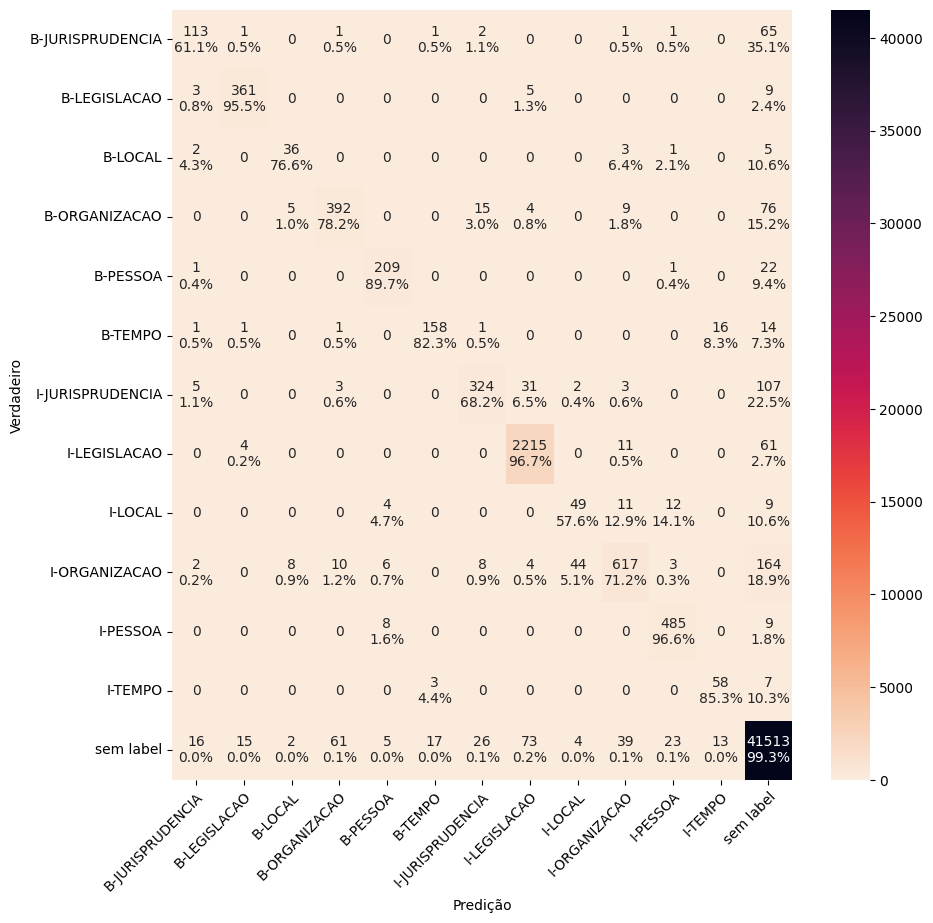

In [46]:
cm_analysis(y_true, y_pred, full_entities_list)

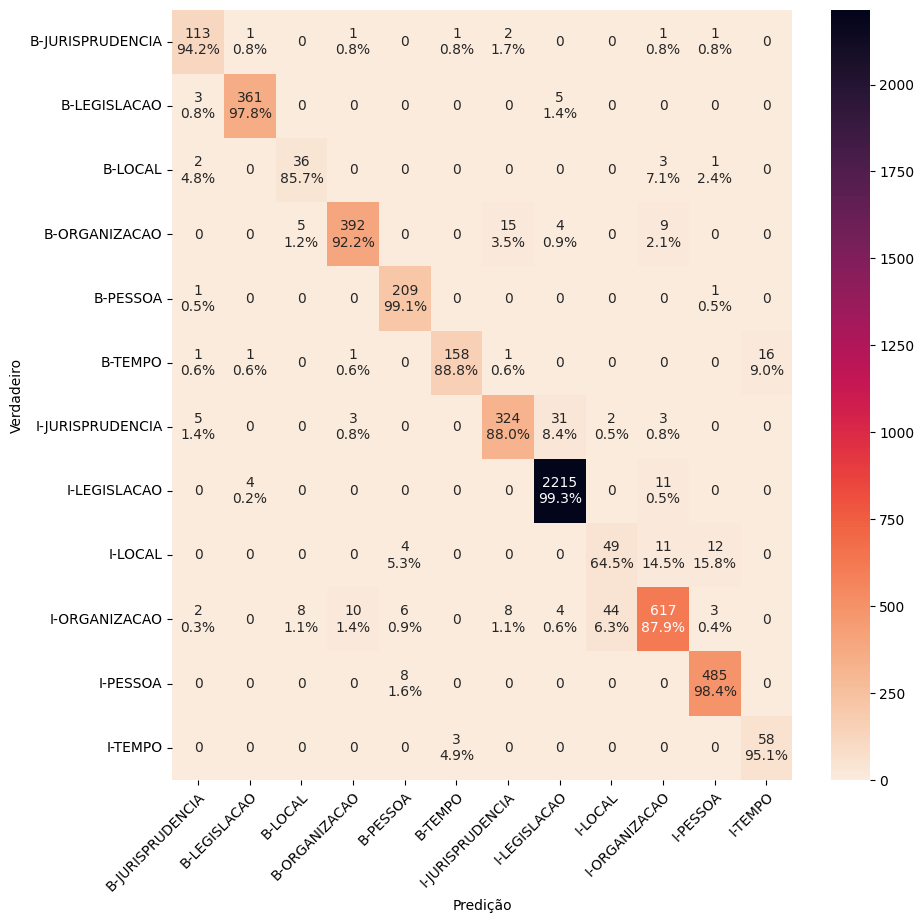

In [47]:
cm_analysis(y_true, y_pred, entities_list)

In [48]:
modified_y_true = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_true]
modified_y_pred = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_pred]
entities_list = np.unique(modified_y_true)
entities_list = [item for item in entities_list if item != 'sem label']

In [49]:
print('\nClassification Report')
print(classification_report(modified_y_true, modified_y_pred, labels = entities_list))


Classification Report


                precision    recall  f1-score   support

JURISPRUDENCIA       0.86      0.67      0.75       660
    LEGISLACAO       0.95      0.97      0.96      2669
         LOCAL       0.57      0.64      0.60       132
   ORGANIZACAO       0.88      0.75      0.81      1367
        PESSOA       0.93      0.96      0.94       735
         TEMPO       0.88      0.90      0.89       260

     micro avg       0.91      0.87      0.89      5823
     macro avg       0.85      0.82      0.83      5823
  weighted avg       0.91      0.87      0.89      5823

